## This project makes use of a number of packages which can be downloaded through the *pip* interface.

The following packages are required:
 * chainer
 * chainercv
 * opencv-python
 * pandas
 * sqlite3
 * numpy

In [1]:
import matplotlib.pyplot as plt
import chainer
from chainercv.utils import read_image
import pandas as pd
import numpy as np
import sqlite3
import warnings 
import logging
import cv2
import timeit

In [2]:
class WIDERFACE:
    db = 'widerface.db'
    con = sqlite3.connect(db)
    bounding_boxes = {
     'val': pd.read_sql_query('select * from bbx_val', con),
     'train': pd.read_sql_query('select * from bbx_train', con)
    }
    file_info = {
     'val': pd.read_sql_query('select * from counts_val', con),
     'train': pd.read_sql_query('select * from counts_train', con),
     'test': pd.read_sql_query('select * from counts_test', con)
    }
    paths = {
        'val' : './data/val/images',
        'train' : './data/train/images',
        'test' : './data/test/images'
        
    }
    
    con.close()
    

In [3]:
WIDERFACE.file_info['train'].head()

,id,image_path,category,box_count
0,1,0--Parade/0_Parade_marchingband_1_849.jpg,0,1
1,2,0--Parade/0_Parade_Parade_0_904.jpg,0,1
2,3,0--Parade/0_Parade_marchingband_1_799.jpg,0,21
3,4,0--Parade/0_Parade_marchingband_1_117.jpg,0,9
4,5,0--Parade/0_Parade_marchingband_1_778.jpg,0,35


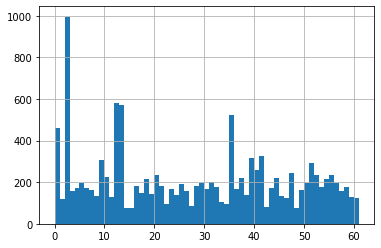

In [4]:
WIDERFACE.file_info['train'].category.hist(bins = 61)

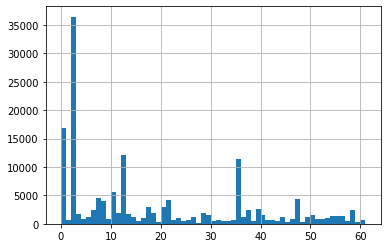

In [5]:
WIDERFACE.bounding_boxes['train'].category.hist(bins = 61)

### Initiate logger for monitoring file processing.

In [6]:
logger = logging.getLogger('logger')
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(filename='filelog.log')
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

In [7]:
from chainer import training
from chainer import cuda
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger
from chainer.datasets import TransformDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms
from chainercv.utils import read_image
from chainercv.visualizations import vis_bbox

### In order to use ChainerCV, bounding boxes must follow the format (y_min, x_min, y_max, x_max).

In [8]:
WIDERFACE.bounding_boxes['train']['y_min'] = WIDERFACE.bounding_boxes['train'].y
WIDERFACE.bounding_boxes['train']['y_max'] = WIDERFACE.bounding_boxes['train'].y_min + WIDERFACE.bounding_boxes['train'].height
WIDERFACE.bounding_boxes['train']['x_min'] = WIDERFACE.bounding_boxes['train'].x
WIDERFACE.bounding_boxes['train']['x_max'] = WIDERFACE.bounding_boxes['train'].x_min + WIDERFACE.bounding_boxes['train'].width

In [9]:
# training_data = []
# train_path = WIDERFACE.paths['train']
# counts_ids = WIDERFACE.bounding_boxes['train']['counts_id']

# for f in WIDERFACE.file_info['train'].itertuples():
#     training_data.append((f'{train_path}/{f.image_path}', f.box_count,
#                          [ [r.y_min, r.x_min, r.y_max, r.x_max] for r in 
#                           WIDERFACE.bounding_boxes['train'][counts_ids == f.id].itertuples() ]))

In [30]:
trials_table = '''trials (
    id integer not null primary key autoincrement,
    model_name text,
    notes text)'''

counts_table = ''' trials_counts (
    id integer not null primary key autoincrement,
    trial_id integer,
    image_path text,
    box_count integer,
    foreign key (trial_id) references trials(id))'''

trials_bbx = '''trials_bbx (
    id integer not null primary key autoincrement,
    trial_id integer,
    counts_id integer,
    image_path text,
    x integer,
    y integer,
    width integer,
    height integer,
    foreign key (trial_id) references trials(id))'''

results_tables = [trials_table, counts_table, trials_bbx]
results_table_names = ['trials', 'trials_counts', 'trials_bbx']

def create_results_db(name = 'results.db'):
    
    con = sqlite3.connect(name)
    if not con:
        raise RuntimeError(f'Unable to load the database: "{name}"')
    cur = con.cursor()
    for tb in results_tables:
        cur.execute(f'create table if not exists {tb}')
    con.close()
    
def drop_results_tables(name = 'results.db'):
    con = sqlite3.connect(name)
    cur = con.cursor()
    for tb in results_table_names:
        cur.execute(f'drop table if exists {tb}')
    con.close()

In [31]:
drop_results_tables()
create_results_db()

In [32]:
def save_results(model_name, notes, counts, bbox):
    con = sqlite3.connect('results.db')
    cur = con.cursor()
    cur.execute('insert into trials(model_name, notes) values(?,?)', (model_name, notes))
    trial_id = cur.lastrowid
    for (c, b) in zip(counts, bbox):
        cur.execute('insert into trials_counts(trial_id, image_path, box_count) values(?,?,?)',
                   (trial_id, c[0], c[1]))
        counts_id = cur.lastrowid
        for box in b:
            cur.execute('insert into trials_bbx(trial_id, counts_id, image_path, x, y, width, height) values(?,?,?,?,?,?,?)',
                       (trial_id, counts_id, c[0], int(box[0]), int(box[1]), int(box[2]), int(box[3])))
            
    con.commit()
    con.close()
    

## This function can be used to generate bounding boxes using Cascade Classifiers through OvenCV.

It takes in a *list* of file paths, a file path to a descriptor of the model to use, a scale factor to apply to the images (1.05 magnifies the image by 5%), and *minimum neighbors* argument which signifies how robust each detection must be.

It outputs two lists. The first contains the image paths and the number of boxes as a pair. The second is a list of the bounding box coordinates found for each image.

In [41]:
def run_opencv_cascade(file_paths, model, scale_factor = 1.1, min_neighbors = 3, use_grayscale = False, use_gpu = True, 
                       n_threads = 5):
    cv2.setNumThreads(n_threads)
    classifier = cv2.CascadeClassifier(model)
    counts = []
    bboxes = []
    start_time = timeit.default_timer()
    for i in file_paths:
        img = cv2.imread(i)
        
        if use_grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Converting a Mat object to a UMat object enables GPU processing.
        if use_gpu:
            img = cv2.UMat(img)

        bboxes_found = classifier.detectMultiScale(img, scale_factor, min_neighbors)
        counts.append((i, len(bboxes_found)))
        bboxes.append(bboxes_found)
    end_time = timeit.default_timer()
    test_runtime = end_time - start_time
    print(f'Found bounding boxes for {len(counts)} images after {test_runtime} seconds.')
    return counts, bboxes

In [39]:
# Jupyter does not like this syntax but I swear it's legal
train_paths = [ f'{WIDERFACE.paths["train"]}/{f}' for f in WIDERFACE.file_info['train']['image_path'] ]
val_paths = [ f'{WIDERFACE.paths["val"]}/{f}' for f in WIDERFACE.file_info['val']['image_path'] ]

### Harr Model

In [40]:
haar_path = './data/opencv_models/haarcascade_frontalface_default.xml'

In [35]:
counts, bbx = run_opencv_cascade(train_paths, haar_path)
save_results('haar','scale: 1.1, neighbors: 3', counts, bbx)

Found bounding boxes for 12880 images after 1456.94907 seconds.


In [27]:
# First go: Found bounding boxes for 12880 images after 1494.7744105000002 seconds.
# Second go: Found bounding boxes for 12880 images after 1456.94907 seconds.

In [38]:
gs_counts, gs_bbx = run_opencv_cascade(train_paths, haar_path, use_grayscale = True)
save_results('haar','grayscale, scale: 1.1, neighbors: 3', gs_counts, gs_bbx)

Found bounding boxes for 12880 images after 1060.9001706999998 seconds.


In [ ]:
# First go: Found bounding boxes for 12880 images after 1060.9001706999998 seconds.
# That's about 8 minutes faster. Not amazing, but helpful.

### Haar Alt

In [45]:
haar_expanded_path = './data/opencv_models/haarcascade_frontalface_alt.xml'

In [46]:
extended_counts, extended_bbx = run_opencv_cascade(train_paths, haar_expanded_path, n_threads = 16)
save_results('haar extended','scale: 1.1, neighbors: 3', gs_counts, gs_bbx)

Found bounding boxes for 12880 images after 1145.9284230999983 seconds.


['./data/train/images/0--Parade/0_Parade_marchingband_1_849.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_904.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_799.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_117.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_778.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_343.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_205.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_106.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_476.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_12.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_273.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_928.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_337.jpg',
 './data/train/images/0--Parade/0_Parade_marchingband_1_579.jpg',
 './data/train/images/0--Parade/0_Parade_Parade_0_90.jpg',
 './data/train/images/0--Parade/0_Parade_marchin